In [1]:
import numpy as np
import astropy.units as u
from astropy.io import ascii
from astropy.time import Time
from zoneinfo import ZoneInfo
from matplotlib.cm import get_cmap
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from datetime import datetime, timedelta
from astropy.coordinates import (AltAz, EarthLocation, SkyCoord, Angle, 
                                 get_sun, get_moon, SkyCoord)

def get_earth_location_and_time(latitude, longitude, height, timezone):
    # SET EARTH LOCATION
    local_coordinates = EarthLocation(lat=latitude, lon=longitude, height=height)
    # SET TIME OF LOCATION
    dt_now = datetime.now(tz=ZoneInfo(timezone))
    local_now = Time(dt_now, location=local_coordinates)
    return local_coordinates, local_now

def create_location_AltAz_timeline(begin_time_ref, end_time_ref, location_time, location_coordinates, N=100):
    timeline = np.linspace(begin_time_ref, end_time_ref, N)*u.hour
    location_timeline = location_time + timeline
    location_timeline_AltAz = AltAz(obstime=location_timeline, location=location_coordinates)
    return location_timeline, location_timeline_AltAz, timeline

def create_sun_and_moon_location_AltAz_timeline(location_timeline, location_timeline_AltAz):
    sun_location_AltAz_timeline = get_sun(location_timeline).transform_to(location_timeline_AltAz)
    moon_location_AltAz_obstime = get_moon(location_timeline).transform_to(location_timeline_AltAz)
    return sun_location_AltAz_timeline, moon_location_AltAz_obstime

def get_location_moon_illumination(location_time):
    sun = get_sun(location_time)
    moon = get_moon(location_time)
    elongation = sun.separation(moon)
    moon_phase_angle = np.arctan2(
        sun.distance*np.sin(elongation), 
        moon.distance - sun.distance*np.cos(elongation)
    )
    moon_illumination = (1 + np.cos(moon_phase_angle))/2.0    
    return moon_illumination

# LOCATION

In [2]:
# DEFINE HERE YOUR GPS COORDINATES
def get_myhome_location_and_time():
    HOME_LAT = -27.480997*u.deg
    HOME_LON = -48.401418*u.deg
    HOME_HEI = 20*u.m
    HOME_TZ = 'America/Sao_Paulo'
    return get_earth_location_and_time(HOME_LAT, HOME_LON, HOME_HEI, HOME_TZ)

# T80-South Location
def get_t80s_location_and_time():
    T80S_LAT = '-30:10:04.31 degrees'
    T80S_LON = '-70:48:20.48 degrees'
    T80S_HEI = 2187
    Chile_timezone = 'America/Santiago'
    t80s_lat = Angle(T80S_LAT)
    t80s_lon = Angle(T80S_LON)
    t80s_hei = T80S_HEI*u.m
    return get_earth_location_and_time(t80s_lat, t80s_lon, t80s_hei, Chile_timezone)

home_coordinates, home_now = get_myhome_location_and_time()
print('home_coordinates: ', home_coordinates)
print('home_now: ', home_now)

home_coordinates:  (3759382.83741384, -4234505.87399877, -2925611.53670425) m
home_now:  2023-05-26 12:35:44.574798


# TIMELINE

In [3]:
# 0 is NOW!
begin_time_ref = -2
end_time_ref = 22
time_label = 'hours [h]'
obstime, home_AltAz_obstime, _time_lapse = create_location_AltAz_timeline(
    begin_time_ref=begin_time_ref, 
    end_time_ref=end_time_ref,
    location_time=home_now, 
    location_coordinates=home_coordinates,
    N=100,
)

# GET MOON AND SUN AT LOCATION

In [4]:
sun_AltAz_obstime, moon_AltAz_obstime = create_sun_and_moon_location_AltAz_timeline(
    location_timeline=obstime, 
    location_timeline_AltAz=home_AltAz_obstime
)

home_moon_illumination = get_location_moon_illumination(home_now)

# ADD SOME OTHER OBJECTS

In [5]:
objects = {
    'LMC': {'c': None, 'ra': 80.89417*u.deg, 'dec': -69.75611*u.deg},
    'SMC': {'c': None, 'ra': 13.15833*u.deg, 'dec': -72.80028*u.deg},
    'Antares': {'c': None, 'ra': 247.35191542*u.deg, 'dec': -26.4300261*u.deg},
    'Acrux': {'c': None, 'ra': 186.6495634*u.deg, 'dec': -63.09909286*u.deg},    
}

n_obj = len(objects)
_cm = get_cmap('magma')
_norm = Normalize(vmin=0, vmax=n_obj-1)

obj_AltAz_obstime = {}
obj_moon_sep = {}
for i, (k, v) in enumerate(objects.items()):
    v['c'] = _cm(_norm(i))
    c = SkyCoord(ra=v['ra'], dec=v['dec'], frame='icrs')
    c_AltAz_home_now = c.transform_to(AltAz(obstime=home_now, location=home_coordinates))
    obj_AltAz_obstime[k] = c_AltAz_home_now.transform_to(home_AltAz_obstime)
    obj_moon_sep[k] = obj_AltAz_obstime[k].separation(moon_AltAz_obstime)

# CREATE A NICE PLOT

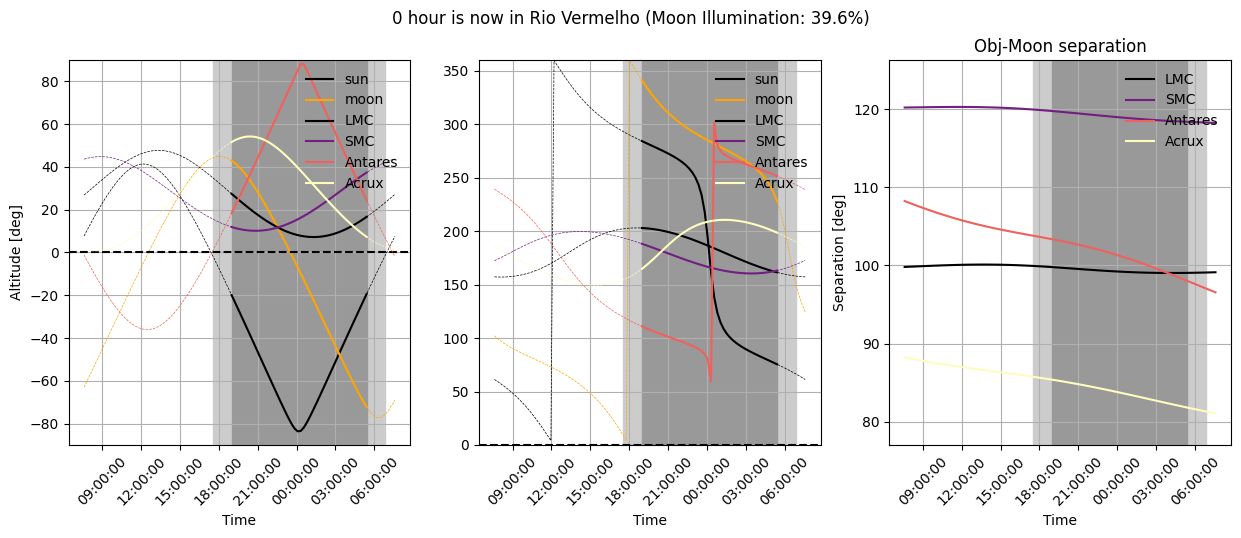

In [6]:
from matplotlib.dates import DateFormatter

mask_night = sun_AltAz_obstime.alt < -0*u.deg
mask_twilight = sun_AltAz_obstime.alt < -18*u.deg

time_lapse = np.asarray([datetime.now() + timedelta(hours=x.value) for x in _time_lapse])

# PLOT
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_size_inches(15, 5)
f.suptitle('0 hour is now in Rio Vermelho (Moon Illumination: {:.1f}%)'.format(home_moon_illumination*100))
ax1.plot(time_lapse, sun_AltAz_obstime.alt, color='k', ls='--', lw=0.5)
ax1.plot(time_lapse, moon_AltAz_obstime.alt, color='orange', ls='--', lw=0.5)
ax1.plot(time_lapse[mask_twilight], sun_AltAz_obstime.alt[mask_twilight], color='k', label='sun')
ax1.plot(time_lapse[mask_twilight], moon_AltAz_obstime.alt[mask_twilight], color='orange', label='moon')


ax1.fill_between(time_lapse, -90, 90, mask_night, color='0.8', zorder=0)
ax1.fill_between(time_lapse, -90, 90, mask_twilight, color='0.6', zorder=0)
ax1.axhline(y=0, ls='--', color='k')
ax1.set_ylabel('Altitude [deg]')

ax2.plot(time_lapse, sun_AltAz_obstime.az, color='k', ls='--', lw=0.5)
ax2.plot(time_lapse, moon_AltAz_obstime.az, color='orange', ls='--', lw=0.5)
ax2.plot(time_lapse[mask_twilight], sun_AltAz_obstime.az[mask_twilight], color='k', label='sun')
ax2.plot(time_lapse[mask_twilight], moon_AltAz_obstime.az[mask_twilight], color='orange', label='moon')
ax2.fill_between(time_lapse, 0, 360, mask_night, color='0.8', zorder=0)
ax2.fill_between(time_lapse, 0, 360, mask_twilight, color='0.6', zorder=0)
ax2.axhline(y=0, ls='--', color='k')
ax2.legend(frameon=False, loc=1)

ax3.set_title('Moon Illumination = {:.2f}%'.format(100*home_moon_illumination))
ax3.fill_between(time_lapse, 0, 360, mask_night, color='0.8', zorder=0)
ax3.fill_between(time_lapse, 0, 360, mask_twilight, color='0.6', zorder=0)
ax3.set_title('Obj-Moon separation')
ax3.set_ylabel('Separation [deg]')

# PLOT OBJECTS
for i, k in enumerate(objects.keys()):
    _c = objects[k]['c']
    _sep = obj_moon_sep[k]
    _obj = obj_AltAz_obstime[k]
    ax1.plot(time_lapse, _obj.alt, color=_c, ls='--', lw=0.5)
    ax1.plot(time_lapse[mask_twilight], _obj.alt[mask_twilight], color=_c, label=k)   
    ax2.plot(time_lapse, _obj.az, color=_c, ls='--', lw=0.5)
    ax2.plot(time_lapse[mask_twilight], _obj.az[mask_twilight], color=_c, label=k)
    ax3.plot(time_lapse, _sep, color=_c, label=k)
    if i:
        if max(_sep.value) > _range[1]:
            _range[1] = max(_sep.value)
        if min(_sep.value) < _range[0]:
            _range[0] = min(_sep.value)        
    else:
        _range = [min(_sep.value), max(_sep.value)]

ax1.set_ylim(-90, 90)
ax2.set_ylim(0, 360)
ax3.set_ylim(_range[0]*0.95, _range[1]*1.05)

for ax in [ax1, ax2, ax3]:
    nbins = (end_time_ref - begin_time_ref)
    formatter = DateFormatter('%H:%M:%S')
    ax.xaxis.set_major_formatter(formatter)
    plt.setp(ax.get_xticklabels(), rotation=45)      
    ax.set_xlabel('Time')
    ax.legend(frameon=False, loc=1)
    ax.grid()

f.savefig('objects_in_sky_HOME.pdf')

In [7]:
# OBJECTS POSITION AT LOCATION NOW
for k, v in obj_AltAz_obstime.items():
    print(f'{k} Alt now: {v.alt[0]:.2f}')
    print(f'{k} Az now: {v.az[0]:.2f}')

LMC Alt now: 26.83 deg
LMC Az now: 157.20 deg
SMC Alt now: 43.65 deg
SMC Az now: 172.27 deg
Antares Alt now: -1.18 deg
Antares Az now: 239.11 deg
Acrux Alt now: 1.27 deg
Acrux Az now: 185.68 deg


# MOON AND SUN NOW AT T80-SOUTH SKY

In [8]:
t80s_coordinates, t80s_now = get_t80s_location_and_time()
begin_time_ref = 0
end_time_ref = 24
time_label = 'hours [h]'
obstime, t80s_AltAz_obstime, _next_24h = create_location_AltAz_timeline(
    begin_time_ref=begin_time_ref, 
    end_time_ref=end_time_ref,
    location_time=t80s_now, 
    location_coordinates=t80s_coordinates
)

sun_AltAz_obstime, moon_AltAz_obstime = create_sun_and_moon_location_AltAz_timeline(
    location_timeline=obstime, 
    location_timeline_AltAz=t80s_AltAz_obstime
)

t80s_moon_illumination = get_location_moon_illumination(t80s_now)

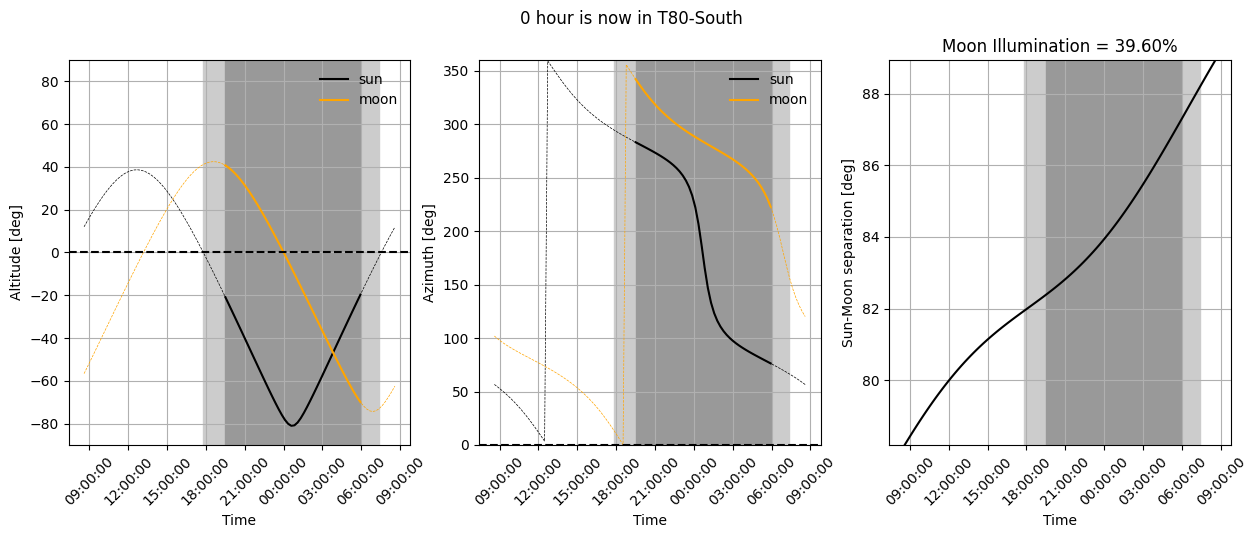

In [9]:
mask_night = sun_AltAz_obstime.alt < -0*u.deg
mask_twilight = sun_AltAz_obstime.alt < -18*u.deg

next_24h = np.asarray([datetime.now(tz=ZoneInfo('America/Santiago')) + timedelta(hours=x.value) for x in _next_24h])

# PLOT
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_size_inches(15, 5)
f.suptitle('0 hour is now in T80-South')
ax1.plot(next_24h, sun_AltAz_obstime.alt, color='k', ls='--', lw=0.5)
ax1.plot(next_24h, moon_AltAz_obstime.alt, color='orange', ls='--', lw=0.5)
ax1.plot(next_24h[mask_twilight], sun_AltAz_obstime.alt[mask_twilight], color='k', label='sun')
ax1.plot(next_24h[mask_twilight], moon_AltAz_obstime.alt[mask_twilight], color='orange', label='moon')
ax1.fill_between(next_24h, -90, 90, mask_night, color='0.8', zorder=0)
ax1.fill_between(next_24h, -90, 90, mask_twilight, color='0.6', zorder=0)
ax1.axhline(y=0, ls='--', color='k')
ax1.set_ylim(-90, 90)
ax1.set_ylabel('Altitude [deg]')
ax1.legend(frameon=False, loc=1)

ax2.plot(next_24h, sun_AltAz_obstime.az, color='k', ls='--', lw=0.5)
ax2.plot(next_24h, moon_AltAz_obstime.az, color='orange', ls='--', lw=0.5)
ax2.plot(next_24h[mask_twilight], sun_AltAz_obstime.az[mask_twilight], color='k', label='sun')
ax2.plot(next_24h[mask_twilight], moon_AltAz_obstime.az[mask_twilight], color='orange', label='moon')
ax2.fill_between(next_24h, 0, 360, mask_night, color='0.8', zorder=0)
ax2.fill_between(next_24h, 0, 360, mask_twilight, color='0.6', zorder=0)
ax2.axhline(y=0, ls='--', color='k')
ax2.set_ylim(0, 360)
ax2.set_ylabel('Azimuth [deg]')
ax2.legend(frameon=False, loc=1)

ax3.set_title('Moon Illumination = {:.2f}%'.format(100*t80s_moon_illumination))
_sep = sun_AltAz_obstime.separation(moon_AltAz_obstime)
ax3.plot(next_24h, _sep, color='k')
_range = min(_sep.value), max(_sep.value)
ax3.fill_between(next_24h, min(_sep.value), max(_sep.value), mask_night, color='0.8', zorder=0)
ax3.fill_between(next_24h, min(_sep.value), max(_sep.value), mask_twilight, color='0.6', zorder=0)
ax3.set_ylabel('Sun-Moon separation [deg]')
ax3.set_ylim(_range)

for ax in [ax1, ax2, ax3]:
    nbins = (end_time_ref - begin_time_ref)
    formatter = DateFormatter('%H:%M:%S', tz=ZoneInfo('America/Santiago'))
    ax.xaxis.set_major_formatter(formatter)
    plt.setp(ax.get_xticklabels(), rotation=45)      
    ax.set_xlabel('Time')
    ax.grid()

f.savefig('sun_and_moon_today_in_t80s.pdf')